# BATDOG <a class="tocSkip">

### *The <font color=red>B</font>ayesian <font color=red>A</font>s<font color=red>t</font>rometric <font color=red>D</font>ust Cart<font color=red>og</font>rapher* <a class="tocSkip">

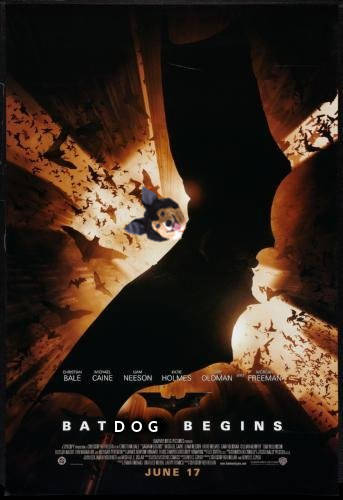

**A Python notebook for processing of parallaxes, comparison with variable star distances and inference of line of sight interstellar extinction to said variable stars.**

This notebook was developed with Table of Contents 2, a Jupyter notebook extension that makes navigating between sections of the code significantly easier. It is strongly recommended that you install this extension. Some details about how to do this can be found here: https://ndres.me/post/best-jupyter-notebook-extensions/ (remember to restart Jupyter after installing nbextensions)

------

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-dependencies" data-toc-modified-id="Imports-and-dependencies-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and dependencies</a></span></li><li><span><a href="#Loading-of-data" data-toc-modified-id="Loading-of-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading of data</a></span><ul class="toc-item"><li><span><a href="#Define-PLR-relation-convenience-functions" data-toc-modified-id="Define-PLR-relation-convenience-functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Define PLR relation convenience functions</a></span></li><li><span><a href="#Setup-a-fake-distribution-of-stars" data-toc-modified-id="Setup-a-fake-distribution-of-stars-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Setup a fake distribution of stars</a></span></li><li><span><a href="#Create-true-parameters-for-the-fake-stars" data-toc-modified-id="Create-true-parameters-for-the-fake-stars-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Create true parameters for the fake stars</a></span></li><li><span><a href="#Model-experimental-parameters-for-the-fake-stars" data-toc-modified-id="Model-experimental-parameters-for-the-fake-stars-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Model experimental parameters for the fake stars</a></span></li><li><span><a href="#Making-up-some-binary-stars" data-toc-modified-id="Making-up-some-binary-stars-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Making up some binary stars</a></span></li></ul></li><li><span><a href="#Setup-of-likelihood-&amp;-priors" data-toc-modified-id="Setup-of-likelihood-&amp;-priors-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Setup of likelihood &amp; priors</a></span><ul class="toc-item"><li><span><a href="#A-debug-helper-function" data-toc-modified-id="A-debug-helper-function-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>A debug helper function</a></span></li><li><span><a href="#Priors" data-toc-modified-id="Priors-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Priors</a></span><ul class="toc-item"><li><span><a href="#Prior-on-extinction" data-toc-modified-id="Prior-on-extinction-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Prior on extinction</a></span></li><li><span><a href="#Prior-on-PLR-parameters" data-toc-modified-id="Prior-on-PLR-parameters-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Prior on PLR parameters</a></span></li><li><span><a href="#Parallax-priors" data-toc-modified-id="Parallax-priors-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Parallax priors</a></span><ul class="toc-item"><li><span><a href="#Prior-on-variable-star-parallax" data-toc-modified-id="Prior-on-variable-star-parallax-3.2.3.1"><span class="toc-item-num">3.2.3.1&nbsp;&nbsp;</span>Prior on variable star parallax</a></span></li><li><span><a href="#Prior-on-binary-star-parallax" data-toc-modified-id="Prior-on-binary-star-parallax-3.2.3.2"><span class="toc-item-num">3.2.3.2&nbsp;&nbsp;</span>Prior on binary star parallax</a></span></li><li><span><a href="#Prior-on-parallax-offset" data-toc-modified-id="Prior-on-parallax-offset-3.2.3.3"><span class="toc-item-num">3.2.3.3&nbsp;&nbsp;</span>Prior on parallax offset</a></span></li></ul></li><li><span><a href="#Prior-on-scale-length" data-toc-modified-id="Prior-on-scale-length-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Prior on scale length</a></span></li><li><span><a href="#Logarithmic-priors-combination" data-toc-modified-id="Logarithmic-priors-combination-3.2.5"><span class="toc-item-num">3.2.5&nbsp;&nbsp;</span>Logarithmic priors combination</a></span></li></ul></li><li><span><a href="#Likelihood-function" data-toc-modified-id="Likelihood-function-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Likelihood function</a></span><ul class="toc-item"><li><span><a href="#Parallax-likelihoods" data-toc-modified-id="Parallax-likelihoods-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Parallax likelihoods</a></span><ul class="toc-item"><li><span><a href="#For-variable-stars" data-toc-modified-id="For-variable-stars-3.3.1.1"><span class="toc-item-num">3.3.1.1&nbsp;&nbsp;</span>For variable stars</a></span></li><li><span><a href="#For-binary-stars---Gaia-measurements" data-toc-modified-id="For-binary-stars---Gaia-measurements-3.3.1.2"><span class="toc-item-num">3.3.1.2&nbsp;&nbsp;</span>For binary stars - Gaia measurements</a></span></li><li><span><a href="#For-binary-stars---external-measurements" data-toc-modified-id="For-binary-stars---external-measurements-3.3.1.3"><span class="toc-item-num">3.3.1.3&nbsp;&nbsp;</span>For binary stars - external measurements</a></span></li></ul></li><li><span><a href="#Likelihood-of-period-data" data-toc-modified-id="Likelihood-of-period-data-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Likelihood of period data</a></span></li><li><span><a href="#Likelihood-of-apparent-magnitude-data" data-toc-modified-id="Likelihood-of-apparent-magnitude-data-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Likelihood of apparent magnitude data</a></span></li><li><span><a href="#Probability-of-the-nuisance-magnitude-parameters" data-toc-modified-id="Probability-of-the-nuisance-magnitude-parameters-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Probability of the nuisance magnitude parameters</a></span></li><li><span><a href="#Logarithmic-likelihoods-combination" data-toc-modified-id="Logarithmic-likelihoods-combination-3.3.5"><span class="toc-item-num">3.3.5&nbsp;&nbsp;</span>Logarithmic likelihoods combination</a></span></li></ul></li><li><span><a href="#Posterior" data-toc-modified-id="Posterior-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Posterior</a></span></li></ul></li><li><span><a href="#Creation-of-a-starting-guess" data-toc-modified-id="Creation-of-a-starting-guess-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Creation of a starting guess</a></span><ul class="toc-item"><li><span><a href="#Define-a-function-that-sets-up-a-ranges-dictionary" data-toc-modified-id="Define-a-function-that-sets-up-a-ranges-dictionary-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Define a function that sets up a <em>ranges</em> dictionary</a></span></li><li><span><a href="#Make-a-dictionary-of-data" data-toc-modified-id="Make-a-dictionary-of-data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Make a dictionary of data</a></span></li><li><span><a href="#Set-initial-expected-hyperparameter-guesses" data-toc-modified-id="Set-initial-expected-hyperparameter-guesses-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Set initial expected hyperparameter guesses</a></span></li><li><span><a href="#Create-a-starting-guess-parameters-vector" data-toc-modified-id="Create-a-starting-guess-parameters-vector-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Create a starting guess parameters vector</a></span></li><li><span><a href="#Maximise-said-starting-guess-in-a-rigorous-process" data-toc-modified-id="Maximise-said-starting-guess-in-a-rigorous-process-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Maximise said starting guess in a rigorous process</a></span><ul class="toc-item"><li><span><a href="#Parallax-maximisation" data-toc-modified-id="Parallax-maximisation-4.5.1"><span class="toc-item-num">4.5.1&nbsp;&nbsp;</span>Parallax maximisation</a></span></li><li><span><a href="#Inference-of-extinctions-from-parallax-guesses" data-toc-modified-id="Inference-of-extinctions-from-parallax-guesses-4.5.2"><span class="toc-item-num">4.5.2&nbsp;&nbsp;</span>Inference of extinctions from parallax guesses</a></span></li></ul></li><li><span><a href="#Export-the-starting-guesses-into-a-(checked)-set-of-dimensions-guesses" data-toc-modified-id="Export-the-starting-guesses-into-a-(checked)-set-of-dimensions-guesses-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Export the starting guesses into a (checked) set of <em>dimensions</em> guesses</a></span></li></ul></li><li><span><a href="#Running-of-emcee" data-toc-modified-id="Running-of-emcee-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Running of emcee</a></span><ul class="toc-item"><li><span><a href="#Define-an-emcee-running-function" data-toc-modified-id="Define-an-emcee-running-function-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Define an emcee running function</a></span></li><li><span><a href="#Define-plotting-functions" data-toc-modified-id="Define-plotting-functions-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Define plotting functions</a></span></li><li><span><a href="#Initialise-emcee-and-try-a-few-first-steps" data-toc-modified-id="Initialise-emcee-and-try-a-few-first-steps-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Initialise emcee and try a few first steps</a></span></li><li><span><a href="#Run-emcee-for-reals-and-check-output" data-toc-modified-id="Run-emcee-for-reals-and-check-output-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Run emcee <em>for reals</em> and check output</a></span></li></ul></li><li><span><a href="#Data-saving-and-plotting" data-toc-modified-id="Data-saving-and-plotting-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Data saving and plotting</a></span><ul class="toc-item"><li><span><a href="#Function-for-computing-sample-quantiles" data-toc-modified-id="Function-for-computing-sample-quantiles-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Function for computing sample quantiles</a></span></li><li><span><a href="#Compare-between-true-&amp;-inferred-values" data-toc-modified-id="Compare-between-true-&amp;-inferred-values-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Compare between true &amp; inferred values</a></span></li></ul></li><li><span><a href="#Deprecated-code" data-toc-modified-id="Deprecated-code-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Deprecated code</a></span><ul class="toc-item"><li><span><a href="#From-the-maximisation-function" data-toc-modified-id="From-the-maximisation-function-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>From the maximisation function</a></span></li><li><span><a href="#More-from-the-maximisation-function-(how-it-was-at-the-start-of-batdog_begins)" data-toc-modified-id="More-from-the-maximisation-function-(how-it-was-at-the-start-of-batdog_begins)-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>More from the maximisation function (how it was at the start of batdog_begins)</a></span></li><li><span><a href="#Run-the-maximisation-function-for-all-stars" data-toc-modified-id="Run-the-maximisation-function-for-all-stars-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Run the maximisation function for all stars</a></span></li><li><span><a href="#Test-of-how-matrices-work-in-numpy" data-toc-modified-id="Test-of-how-matrices-work-in-numpy-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Test of how matrices work in numpy</a></span></li><li><span><a href="#Old-ranges-code" data-toc-modified-id="Old-ranges-code-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Old ranges code</a></span></li></ul></li></ul></div>

# Imports and dependencies
------

Specify directories

In [1]:
# Directory where we can find data for plotting
data_dir = 'data/'

Import packages

In [2]:
# Packages you probably have:
import numpy as np
from scipy.optimize import minimize  # Used in a few places for minimisation
from scipy.stats import norm  # Fast normal distribution evaluator
import pandas as pd
import sys
import matplotlib.pyplot as plt
#import progressbar  # for timing MCMC running

# Packages you might not have:
import emcee  # MCMC package
import corner  # For plots later

# Local .py files that should be in the same dir as this notebook:
# <none>

# Loading of data
------

## Define PLR relation convenience functions
We define a PLR relation class with a number of useful methods. Each instance stores its own PLR parameters.

In [3]:
def PLR_magnitude(a, b, P):
    """Returns the result of the metallacity-independent Leavitt Law given a 
    period.
    """
    return a * np.log10(P) + b


def PLR_period(a, b, m):
    """Returns the result of the metallacity-independent Leavitt Law given a 
    magnitude.
    """
    return np.power(10, (m-b)/a)

## Setup a fake distribution of stars
Create a fake data distribution, fuck with it, and go from there.
Try to sample stars from a unifrom density:

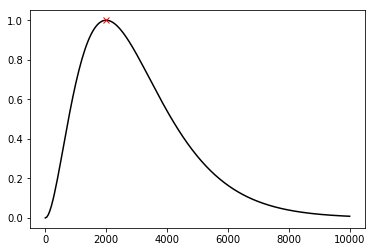

In [4]:
def true_parallax(r):
    """Returns what the exact true parallax 
    should be in arcsecs for a given r."""
    return 1.0/r
    

def stellar_distribution(r, L, fact=1):
    """Returns pdf of a decreasing volume density distribution.
    L    = scale length
    fact = in case we need the -ve of the function and as a 
           factor too to normalise it
    """
    return fact/(2*L**3) * r**2 * np.exp(-r/L)


# Set some parameters
N_stars = 50  # number of stars
scale = 1000  # scale factor in pc to apply, roughly half the mode of the pdf

# Work out the maximum of our distribution
pdf_max_x = scale * 2
pdf_max_y = stellar_distribution(pdf_max_x, scale)

# Normalise the distribution to have its max at 1 for sampling
factor = 1.0 / pdf_max_y 

# Quick test of the distribution
hi = np.linspace(0, scale*10, num=200)
plt.plot(hi, stellar_distribution(hi, scale, fact=factor), 'k-')
plt.plot([pdf_max_x], stellar_distribution(pdf_max_x, scale, 
                                           fact=factor), 'rx')
plt.show()

## Create true parameters for the fake stars

Let's sample the real location of the stars

In [5]:
# Use a defined start random number for repeatability.
np.random.seed(42)

# Some names for star samples, currently just consecutive integers
sampled_ids = pd.Series(list(range(0, N_stars)))

# A pandas DataFrame for all true and experimental data
data = pd.DataFrame(sampled_ids, columns=['ID'])

# Assign a random ra and dec to every star
data['ra'] = pd.Series(np.random.rand(N_stars) * 360)
data['dec'] = pd.Series((np.random.rand(N_stars) - 0.5)*180)

# Sample stellar_distribution to assign distance values to each star
i = 0
r_true = np.zeros(N_stars)
while i < N_stars:
    # Create a test r of size 13 times that of the scale and a deviate test_p 
    # to compare with the interval
    test_r = np.random.rand() * scale * 13
    test_p = np.random.rand()
    
    # See if the test point is in the distribution or not
    if test_p < stellar_distribution(test_r, scale, fact=factor):
        r_true[i] = test_r
        i += 1

# Assign r and implied parallax values we've got to the data frame
data['r_true'] = pd.Series(r_true)
data['omega_true'] = pd.Series((1 / r_true)*1e3)

Let's assign stellar parameters from a PLR relation we're gonna make up for funsies.

In [6]:
band_names = ['E', 'M', 'I']
a_true = [-2.9, -2.8, -2.7]
b_true = [ 2.9,  3.0,  3.1]
s_true = [ 0.1,  0.3,  0.5]
N_bands = len(band_names)  # number of bands

Use the PL relation to infer values for things like magnitude.

In [7]:
# Calculate PLR parameters
# Periods between 5 to 20 days.
data['P_true'] = pd.Series((20-5)*np.random.rand(N_stars) + 5)

# Cycle over bands and make up absolute magnitudes, extinctions and app. magn.
for i, j in zip(band_names, range(N_bands)):
    band = '_true' + '_' + i
    
    # Calculate absolute magnitude from PLR and add disperion, std.d. of s_true
    data['M'+band] = (pd.Series(
                            PLR_magnitude(a_true[j], b_true[j], data['P_true']) 
                            + np.random.normal(loc=0, scale=s_true[j])))
    
    # Extinction is between (j)/nbands + 1.2 and 0.4.
    data['A'+band] = pd.Series((j/N_bands + 1.2 - 0.4)*np.random.rand(N_stars) + 0.4)
    data['m'+band] = (pd.Series(data['M'+band] + 5*np.log10(data['r_true']/10)) 
                      + data['A'+band])

## Model experimental parameters for the fake stars

Now, let's sample some experimental values by messing true values up with random and systematic errors.

In [8]:
def parallax_error_estimator(magnitude, N_stars):
    """Models parallax error according to Gaia collaboration 
    2018 - Summary of contents & survery properties
    - - - - - - - - - - 
     m   sigma_omega [mas]
    <15  0.02-0.04
     17  0.10
     20  0.70
     21  2.00
    """
    # Always 0.02 below 11
    magnitude = np.where(magnitude <= 11, 0.02, 
                         magnitude)
    
    # Make it big for over 21
    magnitude =  np.where(magnitude > 21, 2 * (magnitude-20), 
                          magnitude)
    
    # Linear between 0.7 at 20, 2.0 at 21
    magnitude = np.where(magnitude > 20, 1.3 * (magnitude-20) + 0.70, 
                         magnitude)
    
    # Linear between 0.1 at 17, 0.7 at 20
    magnitude = np.where(magnitude > 17, 0.20 * (magnitude-17) + 0.10, 
                         magnitude)
    
    # Linear between 0.04 at 15, 0.1 at 17
    magnitude = np.where(magnitude > 15, 0.03 * (magnitude-20) + 0.04, 
                         magnitude)
    
    # Linear between 0.02 at 11, 0.04 at 15
    magnitude = np.where(magnitude > 11, 0.005 * (magnitude-20) + 0.02, 
                         magnitude)
    
    # Add a bit of random error & return
    return magnitude * np.random.normal(loc=1, scale=0.2, size=N_stars)


"""Parallax"""
omega_0_true = -0.0  # in mas
parallax_errors = parallax_error_estimator(data['m_true_I'], N_stars) / 5 ################## BIG CHEEKY DIVISION HERE
data['omega_exp'] = (data['omega_true'] + omega_0_true
                     + np.random.normal(loc=0, scale=1, size=N_stars) 
                     * parallax_errors)
data['omega_sigma'] = np.abs(parallax_errors)


"""Period"""
# Typical 1-2% P error
period_errors = data['P_true'] * np.random.normal(loc=0, scale=0.015, size=N_stars)
data['P_exp'] = data['P_true'] + period_errors
data['P_sigma'] = np.sqrt(np.abs(period_errors)**2 + 0.01**2)


"""Apparent magnitude (uncorrected for extinction) & extinction estimates"""
# Typical errors from Scowcroft 2016 - typical 0.01 mag
# Cycle over all my bands
# Cycle over bands and make up absolute magnitudes, extinctions and app. magn.
for i, j in zip(band_names, range(N_bands)):
    band = '_' + i
    app_magnitude_errors = np.random.normal(loc=0, scale=0.01, size=N_stars)
    data['m_exp'+band] = data['m_true'+band] + app_magnitude_errors
    data['m_sigma'+band] = np.sqrt(np.abs(app_magnitude_errors)**2 + 0.01**2)
    data['A_exp'+band] = data['A_true'+band] * ((0.9-0.5)*np.random.rand(N_stars) + 0.5)
    data['A_sigma'+band] = 0.3 * data['A_exp'+band]   # 30% error on all



"""Inferred absolute magniture from the test PLR"""
### THIS CURRENTLY JUST USES INPUT ERROR - needs knowledge of relationship error also
# We are assuming that the scatter is much greater than the period error
# to justify M being treated as a Gaussian deviate.
#data['M_exp'] = pd.Series(test_PLR.magnitude(data['P_exp']) + data['s_true'])
#data['M_sigma'] = pd.Series(np.sqrt(
#            (test_PLR.read_band_a() * data['P_sigma']/data['P_exp'] 
#             * np.log(data['P_exp']))**2 
#            + (0 * test_PLR.read_band_b())**2
#            + (0 * dispersion_guess)**2))

# """Inferred radii from the test PLR"""
# data['r_exp'] = np.power(10, (data['m_exp'] 
#                              - data['M_exp']) / 5 + 1)
# data['r_exp_u'] = np.power(10, (data['m_exp'] + data['m_sigma']
#                                - data['M_sigma']) / 5 + 1)
# data['r_exp_l'] = np.power(10, (data['m_exp'] - data['m_sigma']
#                                + data['M_sigma']) / 5 + 1)

# Output some data so far to look at what our results are like
data[['m_true'+band, 'omega_true', 'omega_exp', 'omega_sigma']]

,m_true_I,omega_true,omega_exp,omega_sigma
0,15.496437,0.244701,0.250466,0.014992
1,12.960576,0.336205,0.332114,0.004065
2,13.881038,0.265480,0.266917,0.002493
3,14.434401,0.241894,0.240588,0.001563
4,13.730762,0.337478,0.340800,0.002941
5,13.474571,0.184286,0.182927,0.002565
6,11.684143,0.641746,0.636596,0.003572
7,13.730539,0.270057,0.277375,0.002961
8,9.295158,1.494269,1.490737,0.004431
9,11.282699,0.530889,0.528731,0.003739


## Making up some binary stars

In addition, we'll use some binary stars to constrain omega_0.

In [9]:
# Name the binaries and again create a data frame
N_binaries = 6  # number of parallax-constraining binary stars
sampled_ids = pd.Series(np.arange(0, N_binaries))
binaries = pd.DataFrame(sampled_ids, columns=['ID'])

# Assign a random ra and dec to every star
binaries['ra'] = pd.Series(np.random.rand(N_binaries) * 360)
binaries['dec'] = pd.Series((np.random.rand(N_binaries) - 0.5)*180)

# Repeat above and pull out some star locations from stellar_distribution
i = 0
r_true = np.zeros(N_binaries)
while i < N_binaries:
    # Create a test r of size 13 times that of the scale and a deviate test_p 
    # to compare with the interval
    test_r = np.random.rand() * scale * 13
    test_p = np.random.rand()
    
    # See if the test point is in the distribution or not
    if test_p < stellar_distribution(test_r, scale, fact=factor):
        r_true[i] = test_r
        i += 1

# Assign r and implied parallax values we've got to the data frame
binaries['r_true'] = pd.Series(r_true)
binaries['omega_true'] = pd.Series((1 / r_true)*1e3)

# Assign an experimental parallax and error
parallax_errors = parallax_error_estimator(13, N_binaries) / 5 ################## BIG CHEEKY DIVISION HERE
binaries['gaia_exp'] = (binaries['omega_true'] + omega_0_true
                     + np.random.normal(loc=0, scale=1, size=N_binaries) 
                     * parallax_errors)
binaries['gaia_sigma'] = np.abs(parallax_errors)

# Same again, but for very precise external parallaxes
parallax_errors = np.random.normal(loc=0, scale=0.0001, size=N_binaries)
binaries['ext_exp'] = (binaries['omega_true'] * (1 + parallax_errors))
binaries['ext_sigma'] = np.sqrt(np.abs(parallax_errors)**2 
                                + 0.0001*binaries['ext_exp']**2)

# Output data for a peek
binaries

,ID,ra,dec,r_true,omega_true,gaia_exp,gaia_sigma,ext_exp,ext_sigma
0,0,280.744342,23.871941,875.557819,1.142129,1.134554,0.004206,1.142054,0.011421
1,1,38.513030,77.765059,2127.109675,0.470122,0.470247,0.003118,0.470101,0.004701
2,2,273.970045,-71.548249,1070.953593,0.933747,0.938648,0.003425,0.933571,0.009338
3,3,194.855968,78.701128,5168.727174,0.193471,0.193094,0.002946,0.193462,0.001935
4,4,346.677121,33.819430,2770.361152,0.360964,0.363595,0.003864,0.360876,0.003617
5,5,123.073980,-77.789329,1706.183410,0.586103,0.583923,0.002594,0.586011,0.005862


# Setup of likelihood & priors
------

**N.B. everything here returns the result of a log.**

## A debug helper function
This function is a convenience to make debug error reporting in the following functions easier.

In [10]:
def debug_output(answer, fname, extra=""):
    """Checks an input array for non-finite values, and outputs the array,
    the name of the function and additional information if there are any.
    """
    # Check for infs and say where they are if so
    if np.all(np.isfinite(answer)) == False:
        print(fname + " encountered infs in these return array values:")
        print("  " + np.where(np.isfinite(answer) == False)[0])
        
        # Print any extra information from the caller
        if len(extra) > 0:
            print("  " + extra)

## Priors
### Prior on extinction
This is simply a uniform prior to constrain the extinction co-efficient to something reasonable.

In [11]:
def prior_extinction(params, r, debug):
    """Currently, a uniform prior between a reasonable range for an 
    extinction co-efficient."""
    # Constants
    max_extinction = 5.0
    min_extinction = 0.0
    
    # Set any incorrect range extinctions to -np.inf (log of 0) and return A
    answer = np.where(np.logical_or(params[r['A']] < min_extinction, 
                                    params[r['A']] > max_extinction), 
                      -np.inf, 0)
    
    if debug:
        debug_output(answer, "prior_extinction")
    
    return answer

### Prior on PLR parameters
Basic uniform priors for a, b and a Jeffreys log-uniform prior on the scatter.

In [12]:
def prior_PLR(params, r, debug):
    """Uniform prior in reasonable ranges for a, b, and a Jeffreys log-uniform 
    prior for scatter.
    """
    # Constants
    max_a = 0.0
    min_a = -5.0
    max_b = 15.0
    min_b = 0.0
    
    # Tests
    a_prior = np.where(np.logical_or(params[r['a']] < min_a, 
                                    params[r['a']] > max_a), 
                      -np.inf, 0)
    b_prior = np.where(np.logical_or(params[r['b']] < min_b, 
                                    params[r['b']] > max_b), 
                      -np.inf, 0)
    
    # Jeffreys first tests that scatter is +ve, then sets to -log of the scattr
    s_prior = np.where(params[r['s']] > 0, -np.log(params[r['s']]), -np.inf) 
    
    if debug:
        debug_output(a_prior, "prior_PLR:a_prior", 
            extra="prior_PLR calculates N_bands values for a")
        
        debug_output(b_prior, "prior_PLR:b_prior", 
            extra="prior_PLR calculates N_bands values for b")
        
        debug_output(s_prior, "prior_PLR:s_prior", 
            extra="prior_PLR calculates N_bands values for s")

    return a_prior + b_prior + s_prior

### Parallax priors

#### Prior on variable star parallax
*Parallax is extremely dangerous. We must deal with it!* The following computes the parallax prior, which is effectively our distance prior but flipped around a bit.

In [13]:
def prior_parallax_variables(params, r, debug):
    """The distance prior but in terms of parallax. We check for any cheeky 
    parallaxes less than zero and set them to -np.inf; if not, set to 
    distance prior.
    """
    # Apply distance prior to main stars
    answer = np.where(params[r['omega']] < 0, -np.inf, 
                      np.log(1/(2 * params[r['L']]**3 * params[r['omega']]**2)) 
                      - 1 / (params[r['omega']] * params[r['L']]))
    
    if debug:
        debug_output(answer, "prior_parallax_variables")
    
    return answer

#### Prior on binary star parallax
Intentionally a separate function to the star parallaxes due to later use needs and the fact that the binary stars may not always be distributed in the same way as the variable stars.

In [14]:
def prior_parallax_binaries(params, r, debug):
    """The distance prior but in terms of parallax. We check for any cheeky 
    parallaxes less than zero and set them to -np.inf; if not, set to 
    distance prior.
    """
    # Apply distance prior to binary stars
    answer = np.where(params[r['omega_B']] < 0, -np.inf, 
                      np.log(1/(2 * params[r['L']]**3 * params[r['omega_B']]**2)) 
                      - 1 / (params[r['omega_B']] * params[r['L']]))
    
    if debug:
        debug_output(answer, "prior_parallax_binaries")
    
    return answer

#### Prior on parallax offset
A uniform prior to constrain $\omega_0$ to a reasonable value.

In [15]:
def prior_parallax_offset(params, r, debug):
    """A uniform prior in a defined reasonable range for omega_0."""
    # Constants (in mas)
    max_omega_0 = 0.200
    min_omega_0 = -0.200
    
    # Check if we're in the correct range
    if (params[r['omega_0']] <= max_omega_0 
        and params[r['omega_0']] >= min_omega_0):
        answer = 0
    else:
        answer = -np.inf
    
    if debug:
        debug_output(answer, "prior_parallax_offset")
    
    return answer

### Prior on scale length
A uniform prior within sensible values.

In [16]:
def prior_scale(params, r, debug):
    """A uniform prior defined in a reasonable range for L."""
    # Constants
    max_scale = 1200
    min_scale = 800
    
    # Check if we're in the correct range
    if (params[r['L']] <= max_scale 
        and params[r['L']] >= min_scale):
        answer = 0
    else:
        answer = -np.inf
    
    if debug:
        debug_output(answer, "prior_scale")
    
    return answer

### Logarithmic priors combination

In [17]:
def prior_total(params, r, debug):
    """Sums all of the priors. Convenience function!"""
    return (np.sum(prior_extinction(params, r, debug))
            + np.sum(prior_PLR(params, r, debug))
            + np.sum(prior_parallax_variables(params, r, debug))
            + np.sum(prior_parallax_binaries(params, r, debug))
            + prior_parallax_offset(params, r, debug)
            + prior_scale(params, r, debug))
    

## Likelihood function
Parts of the likelihood fn are defined here.

### Parallax likelihoods

#### For variable stars

In [18]:
def likelihood_parallax_variables(params, r, data, debug):
    """Returns a normal distribution evaluated at the measured Gaia parallax 
    value, with:
    
    mean = the inferred parallax value plus the Gaia zero-point offset
    standard deviation = the error on the Gaia parallax value
    """
    # Pull parallax likelihood from our normal distribution
    answer = np.log(norm(params[r['omega']] + params[r['omega_0']], 
                         data['omega_sigma']).pdf(data['omega_exp']))
    
    if debug:
        debug_output(answer, "likelihood_parallax_variables")
    
    return answer

#### For binary stars - Gaia measurements

In [19]:
def likelihood_parallax_binaries_gaia(params, r, data, debug):
    """Returns a normal distribution evaluated at the measured Gaia parallax 
    value, with:
    
    mean = the inferred parallax value plus the Gaia zero-point offset
    standard deviation = the error on the Gaia parallax value
    """
    # Pull parallax likelihood from our normal distribution
    answer = np.log(norm(params[r['omega_B']] + params[r['omega_0']], 
                         data['gaia_sigma']).pdf(data['gaia_exp']))
    
    if debug:
        debug_output(answer, "likelihood_parallax_binaries_gaia")
    
    return answer

#### For binary stars - external measurements

In [20]:
def likelihood_parallax_binaries_ext(params, r, data, debug):
    """Returns a normal distribution evaluated at the measured external 
    parallax value, with:
    
    mean = the inferred parallax value
    standard deviation = the error on the parallax value
    """
    # Pull parallax likelihood from our normal distribution
    answer = np.log(norm(params[r['omega_B']], 
                         data['ext_sigma']).pdf(data['ext_exp']))
    
    if debug:
        debug_output(answer, "likelihood_parallax_binaries_ext")
    
    return answer

### Likelihood of period data

In [21]:
def likelihood_period(params, r, data, debug):
    """Returns the likelihood of the inferrred intrinsic period parameters,
    pulled from a normal distribution with:
    mean = P_intrinsic
    standard deviation = error on the measured period
    """
    # Pull likelihood from normal distribution
    answer = np.log(norm(params[r['P']], data['P_sigma']).pdf(data['P_exp']))
    
    if debug:
        debug_output(answer, "likelihood_period")
    
    return answer

### Likelihood of apparent magnitude data

In [22]:
def likelihood_app_mag(params, r, data, debug):
    """Evaluates the Leavitt law to evaluate the likelihood of the inferred
    apparent magnitude data.
    
    Typically, this function is a common cause of issues, and also has a lot of 
    evaluations to perform. It is optimised by using element-wise numpy array
    evaluations of a number of parameters.
    """    
    # Mean is at the Leavitt law implied apparent magnitude
    # N.B. parameters are reshaped into numpy arrays, where the horizontal axis 
    # (0) is the star number, and the vertical axis (1) is the band
    mean = (params[r['a']].reshape(data['N_bands'], 1) 
            * np.log10(params[r['P']]) 
            + params[r['b']].reshape(data['N_bands'], 1)
            + params[r['A']].reshape(data['N_bands'], data['N_stars']) 
            - 5*np.log10(params[r['omega']]) 
            + 10)
    
    # Standard deviation is at the scatter plus the error on magnitude
    # measurements, added in quadrature
    standard_deviation = np.sqrt(params[r['s']].reshape(data['N_bands'], 1)**2 
                                 + data['m_sigma']**2)
    
    # We evaluate a normal distribution of the above values at the measured
    # apparent magnitude value
    distribution = norm(mean, standard_deviation).pdf(data['m_exp'])
    
    # We only take logs when the distribution isn't gonna make it be infinity.
    # This catches a... very... common warning message (thank me later)
    answer = np.where(distribution > 1e-320, np.log(distribution), -np.inf)
       
    if debug:
        debug_output(answer, "likelihood_app_mag")

    return answer

### Probability of the nuisance magnitude parameters

In [23]:
def likelihood_nuisance(params, r, debug):
    """Currently just a test that the apparent magnitudes and periods are 
    within reasonable ranges.
    """
    # Constants
    max_P = 40
    min_P = 1
    
    # Test apparent and absolute magnitudes
    test_P = np.logical_or(params[r['P']] > max_P, params[r['P']] < min_P)
    answer = np.where(test_P, -np.inf, 0)
    
    if debug:
        debug_output(answer, "likelihood_nuisance")
    
    return answer

### Logarithmic likelihoods combination

In [24]:
def likelihood_total(params, ranges, data, debug):
    """Sums all of the likelihood functions. Convenience function!"""
    return (np.sum(likelihood_parallax_variables(params, ranges, 
                                                   data, debug))
            + np.sum(likelihood_parallax_binaries_gaia(params, ranges, 
                                                       data, debug))
            + np.sum(likelihood_parallax_binaries_ext(params, ranges, 
                                                      data, debug))
            + np.sum(likelihood_period(params, ranges, data, debug))
            + np.sum(likelihood_app_mag(params, ranges, data, debug))
            + np.sum(likelihood_nuisance(params, ranges, debug)))

## Posterior
The last prep step! This function defines our log posterior.

In [25]:
def posterior(params, ranges, data, debug=False):
    """Sums all of the logarithmic likelihoods and priors."""
    return (likelihood_total(params, ranges, data, debug) 
            + prior_total(params, ranges, debug))

# Creation of a starting guess
------

For any decent number of stars, the model has a huge number of dimensions. To improve the convergence time of the model, we can use function minimisation methods for each individual star and some intuition with hyperparameters to have a guess that's at a good initial probability.

## Define a function that sets up a *ranges* dictionary

In [26]:
def create_new_ranges_dict(N_stars, N_binaries, N_bands):
    """Because emcee needs to take a 1D position vector as its parameters 
    argument, it's necessary to keep a dictionary that 
    tells us what each parameter is.
    
    This function is lovely and helpful and makes it for you. How kind!
    """
    ranges = {}
    ranges['omega_0'] = 0
    ranges['L'] = 1    
    ranges['a'] = ranges['L'] + 1 + np.arange(N_bands)
    ranges['b'] = ranges['a'][-1] + 1 + np.arange(N_bands)
    ranges['s'] = ranges['b'][-1] + 1 + np.arange(N_bands)
    ranges['omega_B'] = ranges['s'][-1] + 1 + np.arange(N_binaries)
    ranges['omega'] = ranges['omega_B'][-1] + 1 + np.arange(N_stars)
    ranges['P'] = ranges['omega'][-1] + 1 + np.arange(N_stars)
    ranges['A'] = ranges['P'][-1] + 1 + np.arange(N_stars*N_bands)
    
    return ranges

## Make a dictionary of data
Infuriatingly, pandas doesn't really have support for 2D or more numpy arrays, and in conjunction with emcee's total lack of support for anything other than numpy arrays, it's necessary to put all the info in data into a dictionary of arrays.

In [27]:
data_emcee = {}

# Make some blank arrays to pop stuff on later
data_emcee['ID'] = np.asarray(data['ID'])
data_emcee['ra'] = np.asarray(data['ra'])
data_emcee['dec'] = np.asarray(data['dec'])
data_emcee['m_exp'] = np.zeros((N_bands, N_stars))
data_emcee['m_sigma'] = np.zeros((N_bands, N_stars))
data_emcee['P_exp'] = np.asarray(data['P_exp'])
data_emcee['P_sigma'] = np.asarray(data['P_sigma'])
data_emcee['omega_exp'] = np.asarray(data['omega_exp'])
data_emcee['omega_sigma'] = np.asarray(data['omega_sigma'])
data_emcee['N_stars'] = N_stars
data_emcee['N_bands'] = N_bands
data_emcee['N_binaries'] = N_binaries
data_emcee['ext_exp'] = np.asarray(binaries['ext_exp'])
data_emcee['ext_sigma'] = np.asarray(binaries['ext_sigma'])
data_emcee['gaia_exp'] = np.asarray(binaries['gaia_exp'])
data_emcee['gaia_sigma'] = np.asarray(binaries['gaia_sigma'])

# Cycle over the bands and pop magnitude data in, making 'm_exp' into an array 
# of shape N_bands x N_good
for a_band, band_number in zip(band_names, range(N_bands)):
    data_emcee['m_exp'][band_number] = data['m_exp_' + a_band]
    data_emcee['m_sigma'][band_number] = data['m_sigma_' + a_band]

## Set initial expected hyperparameter guesses

In [28]:
guess_omega_0 = 0.0
guess_L = 1000
guess_a = [-2.92, -2.78, -2.67]
guess_b = [ 2.92,  3.04,  3.13]
guess_s = [ 0.12,  0.28,  0.54]

## Create a starting guess parameters vector

In [29]:
ranges = create_new_ranges_dict(N_stars, N_binaries, N_bands)

# Make up our starting guess as a long numpy array. This takes some faff and
# appending to get right.
starting_guess = np.array([guess_omega_0, guess_L])
starting_guess = np.append(starting_guess, guess_a)
starting_guess = np.append(starting_guess, guess_b)
starting_guess = np.append(starting_guess, guess_s)
starting_guess = np.append(starting_guess, data_emcee['ext_exp'])
hacked_guess = starting_guess.copy()  # A special guess for omega solving later

"""
starting_guess = np.append(starting_guess, data_emcee['omega_exp'])
starting_guess = np.append(starting_guess, data_emcee['P_exp'])
starting_guess = np.append(starting_guess, np.zeros(N_bands * N_stars))
"""

"\nstarting_guess = np.append(starting_guess, data_emcee['omega_exp'])\nstarting_guess = np.append(starting_guess, data_emcee['P_exp'])\nstarting_guess = np.append(starting_guess, np.zeros(N_bands * N_stars))\n"

## Maximise said starting guess in a rigorous process
To dramatically improve emcee's chances, the following cells attempt to make our starting guess as likely as possible before we even begin. Expect to spend some time fiddling to get the best guess for any input data.

It works by first inferring the most likely parallaxes, and then using these to infer extinctions. Doing it in this order has been experimentally shown to stop likelihood_app_mag from being downright rude.

### Parallax maximisation

First, let's estimate parallax in three ways: with the Gaia values, with the PLR and with the distance prior parameter. We'll compare their individual likelihoods and only use the best one.

In [30]:
# Find the band with the estimated least scatter
best_band_arg = np.argmin(guess_s)
best_band = band_names[best_band_arg]

# The Gaia parallaxes
omega_gaia = data_emcee['omega_exp']
params_gaia = np.append(hacked_guess, omega_gaia)
likelihood_gaia = (prior_parallax_variables(params_gaia, ranges, False)
                    + likelihood_parallax_variables(params_gaia, ranges, 
                                                    data_emcee, False))
# The PLR parallaxes
omega_PLR = np.power(10, (guess_a[best_band_arg] *np.log10(data_emcee['P_exp'])
                          + guess_b[best_band_arg]
                          + data['A_exp_' + best_band]
                          + 10 - data['m_exp_' + best_band]) / 5)
params_PLR = np.append(hacked_guess, omega_PLR)
likelihood_PLR = (prior_parallax_variables(params_PLR, ranges, False)
                    + likelihood_parallax_variables(params_PLR, ranges, 
                                                    data_emcee, False))
# The prior parallaxes
omega_prior = np.repeat(guess_L, N_stars)
params_prior = np.append(hacked_guess, omega_PLR)
likelihood_prior = (prior_parallax_variables(params_prior, ranges, False)
                    + likelihood_parallax_variables(params_prior, ranges, 
                                                    data_emcee, False))

# Find where Gaia is the best
best_gaia = np.where(np.logical_and(
                         np.logical_and(
                             np.isfinite(likelihood_gaia),
                             likelihood_gaia > likelihood_PLR),
                         likelihood_gaia > likelihood_prior))[0]

# Find where the PLR is the best
best_PLR = np.where(np.logical_and(
                         np.logical_and(
                             np.isfinite(likelihood_PLR),
                             likelihood_PLR > likelihood_gaia),
                         likelihood_PLR > likelihood_prior))[0]

# Find where the prior is the best
best_prior = np.where(np.logical_and(
                         np.logical_and(
                             np.isfinite(likelihood_prior),
                             likelihood_prior > likelihood_PLR),
                         likelihood_prior > likelihood_gaia))[0]

# Pop all the best guesses in a single array
omega_best = np.append(np.append(omega_gaia[best_gaia], 
                                 omega_PLR[best_PLR]), 
                                 omega_prior[best_prior])

# Keep a list of stars that worked, and sort it so it's in ascending order
omega_success_guessed = np.append(np.append(best_gaia, best_PLR), best_prior)
omega_success_guessed = np.sort(omega_success_guessed)

# Tell the user about how it all went =)
print("Guessing done. Where each different method was the best estimator:")
print("  gaia:  {}".format(len(best_gaia)))
print("  PLR:   {}".format(len(best_PLR)))
print("  prior: {}".format(len(best_prior)))
print("We failed to make a guess on {} stars."
      .format(N_stars - len(omega_success_guessed)))

Guessing done. Where each different method was the best estimator:
  gaia:  50
  PLR:   0
  prior: 0
We failed to make a guess on 0 stars.


/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


Next, let's use scipy to hone in on the best values for our parallaxes:

In [31]:
def function_to_minimise(omega, starting_guess, ranges, data):
    """This function is mostly just to make interfacing between scipy and
    my functons possible. Note that we multiply by -1 because scipy's
    algorithms minimise, not maximise.
    """
    # Pop the singular parallax on the end of a position vector
    params = np.append(starting_guess, omega)
    
    return -1 * (prior_parallax_variables(params, ranges, False)
                 + likelihood_parallax_variables(params, ranges, data, False))

# Keep a list of all the parallaxes that get through this step
omega_success_maximised = np.array([]).astype('int64')
omega_fails_maximised = np.array([]).astype('int64')

# Keep a list of the actual parallaxes themselves that have worked
omega_maximised = np.array([])

# Make hacked ranges and data dictionaries that ensures later methods only
# look for one star
hacked_ranges = ranges.copy()
hacked_ranges['omega'] = hacked_ranges['omega'][0]
hacked_ranges['P'] = hacked_ranges['omega'] + 1
hacked_ranges['A'] = hacked_ranges['P'] + 1 + np.arange(N_bands)

hacked_data = data_emcee.copy()
hacked_data['N_stars'] = 1

# Cycle over our stars
for a_star in omega_success_guessed:
    print("Trying to maximise star {}...".format(a_star))
    
    # We cheat a bit here and make a fake data dict for interfacing purposes
    hacked_data['omega_exp'] = data_emcee['omega_exp'][a_star]
    hacked_data['omega_sigma'] = data_emcee['omega_sigma'][a_star]

    # Do the scipy bit and get an OptimizeResult type object back
    result = minimize(function_to_minimise, omega_best[a_star], 
                          args=(hacked_guess, hacked_ranges, hacked_data), 
                          method='Nelder-Mead',
                          options={'maxiter':2000, 'disp':True})
        
    if result.success:
        print("  Successfully maximised for star {}\n".format(a_star))
        # Keep a record of star numbers that worked
        omega_success_maximised = np.append(omega_success_maximised, a_star)
        omega_maximised = np.append(omega_maximised, result.x)
        
    else:
        print("~~FAILED to maximise star {}\n".format(a_star))
        omega_fails_maximised = np.append(omega_fails_maximised, a_star)
       
print("Successful maximisations: {}".format(len(omega_success_maximised)))
print("Failed maximisations: {}".format(len(omega_fails_maximised)))

Trying to maximise star 0...
Optimization terminated successfully.
         Current function value: 15.363044
         Iterations: 8
         Function evaluations: 16
  Successfully maximised for star 0

Trying to maximise star 1...
Optimization terminated successfully.
         Current function value: 14.628201
         Iterations: 9
         Function evaluations: 18
  Successfully maximised for star 1

Trying to maximise star 2...
Optimization terminated successfully.
         Current function value: 13.702864
         Iterations: 10
         Function evaluations: 20
  Successfully maximised for star 2

Trying to maximise star 3...
Optimization terminated successfully.
         Current function value: 13.029083
         Iterations: 9
         Function evaluations: 18
  Successfully maximised for star 3

Trying to maximise star 4...
Optimization terminated successfully.
         Current function value: 14.356197
         Iterations: 10
         Function evaluations: 20
  Successfully 

/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log



         Current function value: 15.868477
         Iterations: 10
         Function evaluations: 20
  Successfully maximised for star 42

Trying to maximise star 43...
Optimization terminated successfully.
         Current function value: 13.890967
         Iterations: 10
         Function evaluations: 20
  Successfully maximised for star 43

Trying to maximise star 44...
Optimization terminated successfully.
         Current function value: 12.470896
         Iterations: 9
         Function evaluations: 18
  Successfully maximised for star 44

Trying to maximise star 45...
Optimization terminated successfully.
         Current function value: 13.648906
         Iterations: 10
         Function evaluations: 20
  Successfully maximised for star 45

Trying to maximise star 46...
Optimization terminated successfully.
         Current function value: 16.213347
         Iterations: 11
         Function evaluations: 22
  Successfully maximised for star 46

Trying to maximise star 47...
Opt

### Inference of extinctions from parallax guesses
Lastly, we're going to infer extinction values from the parallax guesses, and check that these values aren't crap by evaluating posterior() for these guesses.

In [32]:
# Make some long 1D arrays to keep the good shit in for the time being
good_omegas = np.array([])
good_periods = np.array([])
good_extinctions = np.array([])

# Keep a record of stars that get past THE FINAL CHALLENGE
good_stars = np.array([])
bad_stars = np.array([])

# Add extra values to hacked_guess so that we can write a test parallax, period
# and extinctions here
hacked_guess = np.append(hacked_guess, np.zeros(2 + N_bands))

# Cycle over our good parallax guesses to make good extinction guesses,
# and add these to starting_guess
for a_star, an_omega in zip(omega_success_maximised, omega_maximised):
    print("Trying to find extinction for star {}...".format(a_star))
    
    # Evaluate the Leavitt Law for extinction
    extinction_guess = (data_emcee['m_exp'][:, a_star] 
                           - starting_guess[ranges['a']]
                           * np.log10(data_emcee['P_exp'][a_star])
                           - starting_guess[ranges['b']]
                           + 5 * np.log10(an_omega) - 10)
    
    # Make a hacked_data containing only star data on DIS STAR
    hacked_data['omega_exp'] = data_emcee['omega_exp'][a_star]
    hacked_data['omega_sigma'] = data_emcee['omega_sigma'][a_star]
    hacked_data['P_exp'] = data_emcee['P_exp'][a_star]
    hacked_data['P_sigma'] = data_emcee['P_sigma'][a_star]
    hacked_data['m_exp'] = data_emcee['m_exp'][:, a_star]
    hacked_data['m_sigma'] = data_emcee['m_sigma'][:, a_star]
    
    # Also hack the guess to only contain data on DIS STAR
    hacked_guess[hacked_ranges['omega']] = an_omega
    hacked_guess[hacked_ranges['P']] = data_emcee['P_exp'][a_star]
    hacked_guess[hacked_ranges['A']] = extinction_guess
    
    print("  guessed extinctions as: {}".format(extinction_guess))
    
    # Evaluate the posterior for this extinction alone
    how_shit_is_this_guess = posterior(hacked_guess, hacked_ranges, 
                                       hacked_data, debug=True)
    
    # Tell the user if batdog can't bork rn
    if np.isfinite(how_shit_is_this_guess):
        print("  Success! posterior() is finite, with a value {}"
              .format(how_shit_is_this_guess))
        print("  star {} will appear in the starting guess. Yay :3\n".format(a_star))
        
        # Jot down all the details of this spiffingly successful star
        good_omegas = np.append(good_omegas, an_omega)
        good_periods = np.append(good_periods, data_emcee['P_exp'][a_star])
        good_extinctions = np.append(good_extinctions, extinction_guess)
        good_stars = np.append(good_stars, a_star)
        
    else:
        print("  FAILURE! posterior() has a value of {}"
              .format(how_shit_is_this_guess))
        print("~~star {} will not appear in the starting guess.\n".format(a_star))
        
        # There are only good stars, and bad stars. ABSOLUTELY NO IN-BETWEEN
        bad_stars = np.append(bad_stars, a_star)

        
# Add all the good shit to a final guess
starting_guess = np.append(starting_guess, good_omegas)
starting_guess = np.append(starting_guess, good_periods)

# (we do something special for extinctions, and reformat the array from being: 
# [star1:band1, star1:band2, star2:band1, star2:band2 ...etc]
# to instead being in band order, like:
# [star1:band1, star2:band1, star1:band2, star2:band2 ...etc]
starting_guess = np.append(starting_guess, 
    good_extinctions.reshape(N_bands, len(good_stars)).T.flatten())
    
# Work out which original stars aren't in the final set
stars_to_remove = np.where(np.isin(np.arange(N_stars), 
                      good_stars) == False)[0]

# Remove the bad ones from data_emcee
keys = list(data_emcee.keys())
keys.remove('m_exp')
keys.remove('m_sigma')
keys.remove('N_stars')
keys.remove('N_bands')
keys.remove('N_binaries')
for a_key in keys:
    data_emcee[a_key] = np.delete(data_emcee[a_key], stars_to_remove)

# We handle magnitudes separately as these are 2D arrays of N_bands x N_stars
data_emcee['m_exp'] = np.delete(data_emcee['m_exp'], stars_to_remove, axis=1)
data_emcee['m_sigma'] = np.delete(data_emcee['m_sigma'], stars_to_remove, 
                                  axis=1)

# Set N to a new value based on how many guesses we have
N_good = len(good_stars)
data_emcee['N_stars'] = N_good

# Make a fresh ranges dictionary based on how many good stars there are
ranges = create_new_ranges_dict(N_good, N_binaries, N_bands)

print("All done! There were {} good stars and {} bad ones."
      .format(N_good, N_stars-N_good))

Trying to find extinction for star 0...
  guessed extinctions as: [0.85628795 0.37695159 1.41182924]
  Success! posterior() is finite, with a value -122.62891288698293
  star 0 will appear in the starting guess. Yay :3

Trying to find extinction for star 1...
  guessed extinctions as: [0.74961905 0.84559281 0.7527976 ]
  Success! posterior() is finite, with a value -91.81728858640267
  star 1 will appear in the starting guess. Yay :3

Trying to find extinction for star 2...
  guessed extinctions as: [0.97576299 0.7728727  1.06677534]
  Success! posterior() is finite, with a value -89.73614807486608
  star 2 will appear in the starting guess. Yay :3

Trying to find extinction for star 3...
  guessed extinctions as: [0.88378283 0.50738092 0.35446311]
  Success! posterior() is finite, with a value -72.43421470653705
  star 3 will appear in the starting guess. Yay :3

Trying to find extinction for star 4...
  guessed extinctions as: [1.11027431 0.2471534  0.38004942]
  Success! posterior()

  guessed extinctions as: [1.35581112 0.22349234 0.35878563]
  Success! posterior() is finite, with a value -116.94949440300968
  star 48 will appear in the starting guess. Yay :3

Trying to find extinction for star 49...
  guessed extinctions as: [1.11870999 0.83135616 0.5724633 ]
  Success! posterior() is finite, with a value -77.42296278860127
  star 49 will appear in the starting guess. Yay :3

All done! There were 50 good stars and 0 bad ones.


In [33]:
N_good

50

## Export the starting guesses into a (checked) set of *dimensions* guesses

In [34]:
posterior(starting_guess, ranges, data_emcee)

-1296.5859696276266

In [35]:
# Some parameters for the MCMC simulation
dimensions = starting_guess.size
walkers = 4 * dimensions

# Extend the starting guess to our number of walkers' dimensions
rng = np.random.RandomState(42)
starting_guesses = starting_guess + 0.0001 * rng.randn(walkers, dimensions)  # SHOULD MULTIPLY BY THE DESIRED RANGE OF PARAMS

# Running of emcee
------

The game is on! It's time to run emcee and see what results we can get.

## Define an emcee running function

In [36]:
def run_emcee_for_me(sampler, steps=100, reset=False, guess=0, 
                     step_increment=1):
    """Auto-runs emcee, giving an update on each step done and 
    estimating runtime.
    """    
    # See if we need to start from a guess
    if type(guess) is int:
        # Set to last sampler position
        last_pos = sampler.chain[:, -1, :]
    else:
        # Set to the guess
        last_pos = guess
        
    # Wipe the sampler's memory if required
    if reset == True:
        sampler.reset()
    
    # A bit of start output
    sys.stdout.write("BATDOG is running!\n  steps={}\n\n".format(steps))
    sys.stdout.flush()
    
    # Loop until we reach steps
    current_step = 1
    while current_step <= steps:
        last_pos, last_prob, last_state = sampler.run_mcmc(last_pos, 
                                                           step_increment)
        sys.stdout.write("\rDone {} steps. ETA: {}"
                         .format(current_step, "W.I.P."))
        sys.stdout.flush()
        current_step += step_increment
    
    # Add a blank line at the end
    sys.stdout.write("\r                                 ")
    sys.stdout.flush()

## Define plotting functions

In [41]:
def plot_chains(sampler, ranges, data_emcee, star=0, binary_star=0, band='', 
                start=False):
    """Plots the current stored chain output for a given star."""
    names = list(ranges.keys())
    
    # Work out what the parameter vector ID of the star is (it may be a bit 
    # less than expected if we had some failures)
    star_p = int(np.where(data_emcee['ID'] == star)[0])
    band_number = band_names.index(band)
    
    # Gets the requisite parameter numbers for a given star, correcting for
    # guess failures removing stars from the emcee model as required
    values = [ranges['omega_0'], 
              ranges['L'], 
              ranges['a'][band_number],
              ranges['b'][band_number],
              ranges['s'][band_number],
              ranges['omega_B'][binary_star], 
              ranges['omega'][star_p], 
              ranges['P'][star_p], 
              ranges['A'][star_p * (band_number + 1)]]
    
    # Check if the user specified a start point to plot from
    if start != False:
        s = start
    else:
        s = 0
    
    fig, ax = plt.subplots(10, figsize=(8, 12), sharex=True)

    # Plots likelihood
    ax[0].plot(sampler.lnprobability.T, '-r', alpha=0.2)
    ax[0].set_ylabel('lnprob')

    # Plots parameter evolution
    j=0  # Parameter to try
    for i in values:
        ax[j+1].plot(sampler.chain[:, s:, values[j]].T, '-k', alpha=0.2);
        ax[j+1].set_ylabel(names[j])
        j += 1
    plt.show()
        
def plot_corner(sampler, ranges, data_emcee, star=0, binary_star=0, band='', 
                start=False):
    """Makes a corner plot using corner.py."""
    names = list(ranges.keys())
    
    # Work out what the parameter vector ID of the star is (it may be a bit 
    # less than expected if we had some failures)
    star_p = int(np.where(data_emcee['ID'] == star)[0])
    band_number = band_names.index(band)
    
    # Gets the requisite parameter numbers for a given star, correcting for
    # guess failures removing stars from the emcee model as required
    values = [ranges['omega_0'], 
              ranges['L'], 
              ranges['a'][band_number],
              ranges['b'][band_number],
              ranges['s'][band_number],
              ranges['omega_B'][binary_star], 
              ranges['omega'][star_p], 
              ranges['P'][star_p], 
              ranges['A'][star_p * (band_number + 1)]]
    
    # Check if the user specified a start point to plot from
    # CURRENTLY NOT IMPLEMENTED
    if start != False:
        s = start
        print("START VALUES AREN'T IMPLEMENTED YET HERE sorry =( =(")
    else:
        s = 0
    
    # Make a corner plot
    corner.corner(sampler.flatchain[:, values], 
                  labels=names, 
                  truths=[omega_0_true, 
                          scale, 
                          a_true[band_number],
                          b_true[band_number],
                          s_true[band_number],
                          binaries['omega_true'][binary_star],
                          data['omega_true'][star],
                          data['P_true'][star], 
                          data['A_true_' + band][star]],
                  quantiles=[0.16, 0.5, 0.84],
                  show_titles=True,
                  title_fmt='.4f',
                  title_kwargs={"fontsize":12},
                  scale_hist=True)
    plt.show()

## Initialise emcee and try a few first steps

In [38]:
# Define the sampler
sampler = emcee.EnsembleSampler(walkers, dimensions, posterior, 
                                args=(ranges, data_emcee), kwargs={'debug':False}, 
                                threads=8)

# Set random state for repeatability
sampler.random_state = rng

%time run_emcee_for_me(sampler, steps=10, guess=starting_guesses)

BATDOG is running!
  steps=10

                                 CPU times: user 428 ms, sys: 80 ms, total: 508 ms
Wall time: 17.9 s


/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in log10
/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in greater
/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in log
/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in log10
/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/scipy/st

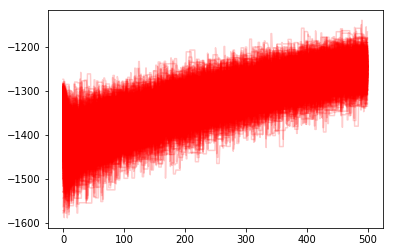

In [245]:
plt.plot(sampler.lnprobability.T, '-r', alpha=0.2)
plt.show()

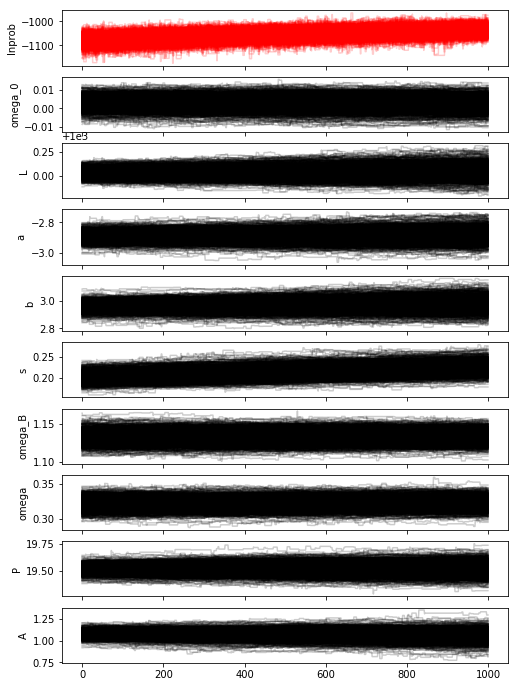

In [63]:
# Change me
star_to_try = 10

# Plot chains output
plot_chains(sampler, ranges, data_emcee, star=star_to_try, binary_star=0, band='E')

## Run emcee *for reals* and check output

In [39]:
%time run_emcee_for_me(sampler, reset=True, steps=500)

BATDOG is running!
  steps=500

                                 CPU times: user 49.3 s, sys: 1min 15s, total: 2min 4s
Wall time: 15min 37s


In [59]:
%time run_emcee_for_me(sampler, reset=True, steps=1000)

BATDOG is running!
  steps=1000

                                 CPU times: user 2min 34s, sys: 4min 58s, total: 7min 32s
Wall time: 33min


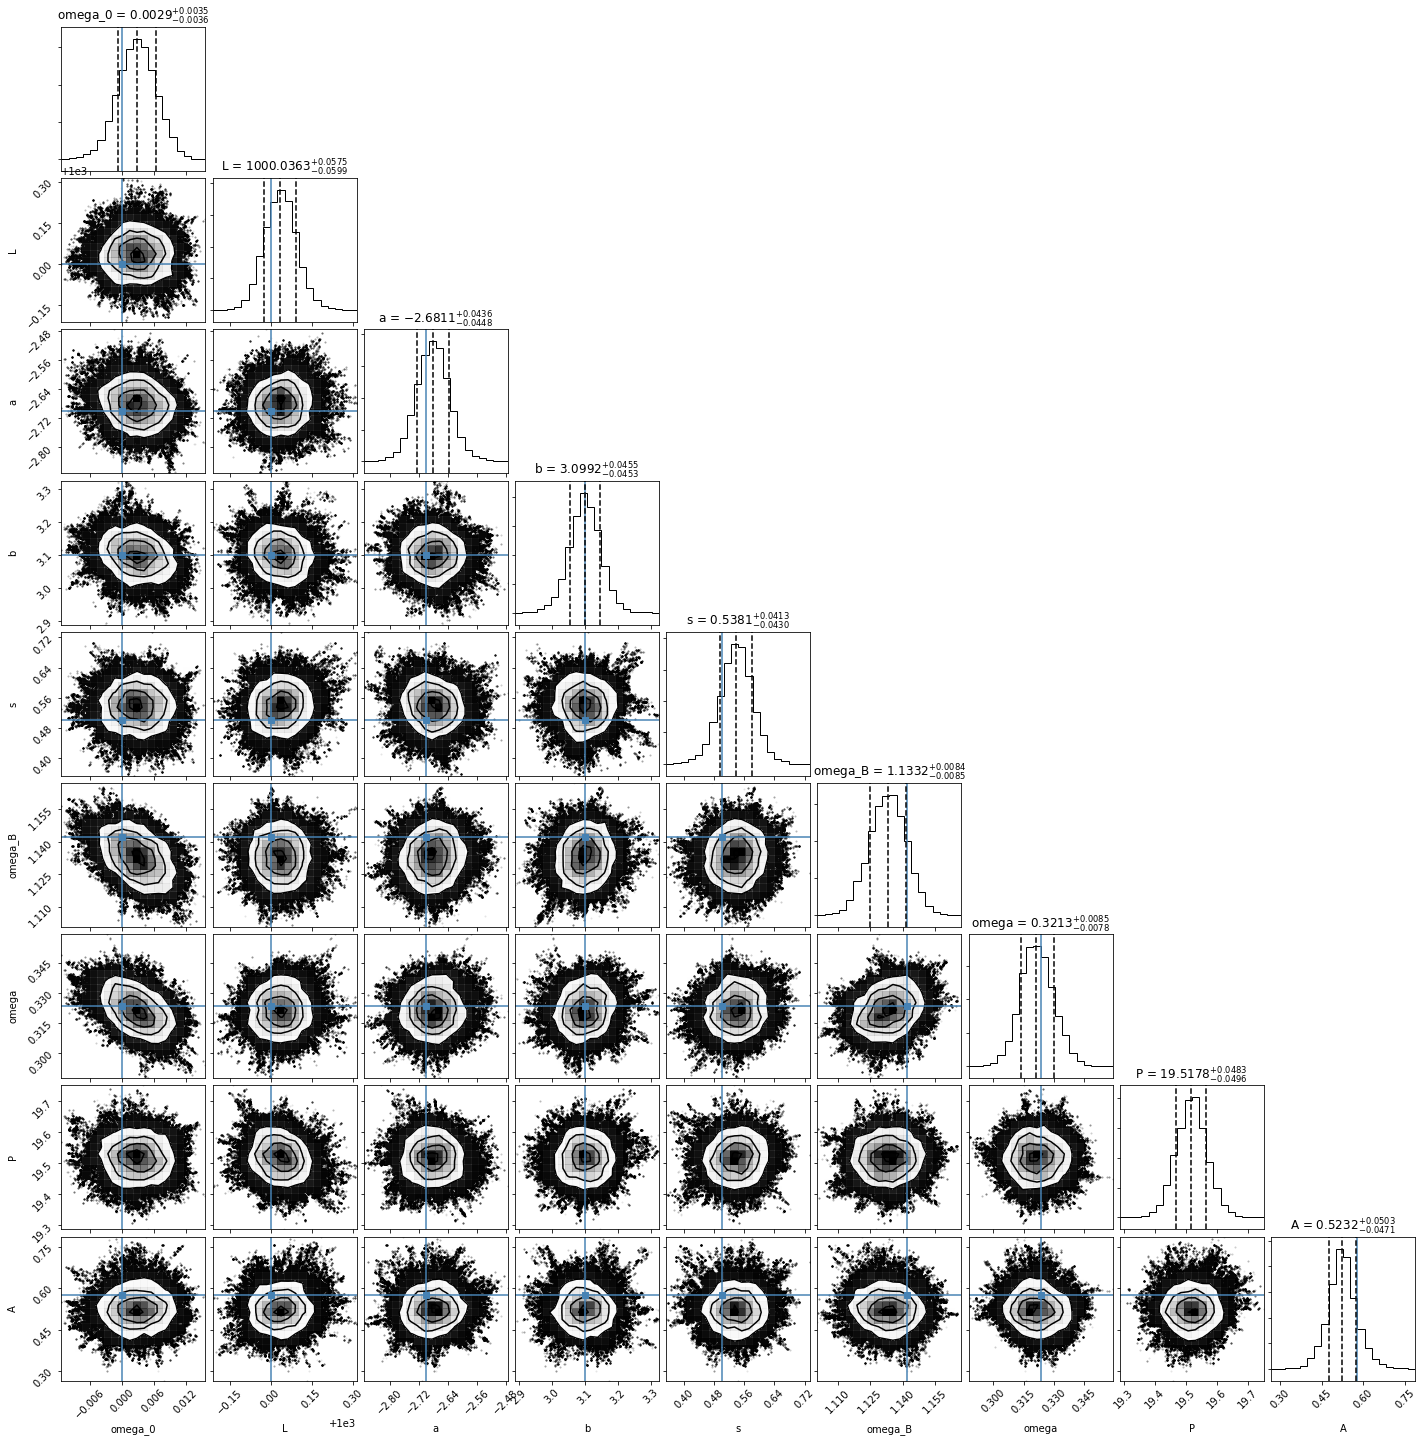

,omega_true,omega_exp,omega_sigma,P_true,P_exp,P_sigma,A_true_E,A_exp_E
10,0.323699,0.324408,0.003493,19.790016,19.49947,0.290718,0.647622,0.377664


In [79]:
# Change me
star_to_try = 10

# Make a corner plot
plot_corner(sampler, ranges, data_emcee, star=star_to_try, binary_star=0, band='I')

# Get data on star star_to_try
data.iloc[[star_to_try]][['omega_true', 'omega_exp', 'omega_sigma', 'P_true', 'P_exp', 'P_sigma', 'A_true_E', 'A_exp_E']]
#data.iloc[[star_to_try]][['omega_true', 'omega_exp', 'omega_sigma', 'm_true', 
#                          'm_exp', 'm_sigma', 'M_true', 'M_exp', 'M_sigma', 
#                          'A_true_E', 'A_exp', 'A_sigma']]

In [78]:
s_true

[0.1, 0.3, 0.5]

# Data saving and plotting
------
First, outline a way to convert back from the emcee format to a format for easy output and comparison.

## Function for computing sample quantiles

In [67]:
def calculate_corner_quantiles(sampler, ranges, data_emcee, data, start=False):
    """Computes requisite quantile levels for all parameters in the model,
    and outputs them to the original data DataFrame object as well as popping
    a, b, s etc parameters in a sensible output.
    """
    
    # Quantiles to work stuff out at. Currently set to the 1sigma level.
    quantiles = np.array([0.16, 0.50, 0.84])
    
    # Get all the parameter names we want to look at
    parameter_names = ['omega_inf', 'P_inf']
    for name in band_names:
        parameter_names.append('A_inf_' + name)
        
    # Initialise rows of the dataframe
    for name in parameter_names:
        data[name] = np.nan
        data[name + '_u'] = np.nan
        data[name + '_l'] = np.nan
    
    # Check if the user specified a start point to plot from
    # CURRENTLY NOT IMPLEMENTED
    if start != False:
        s = start
        print("START VALUES AREN'T IMPLEMENTED YET HERE sorry")
    else:
        s = 0
    
    # Loop over all parameters for stars
    for a_star in range(N_good):
        # We grab the original ID of the star so we can put it in the right
        # place in the original DataFrame. Any failed stars will shift the
        # order of everything a bit, making this necessary.
        a_star_ID = data_emcee['ID'][a_star]
        
        # Firstly, do the band independent bits
        # Omega
        data.loc[a_star_ID, 'omega_inf' + '_l'],\
            data.loc[a_star_ID, 'omega_inf'],\
            data.loc[a_star_ID, 'omega_inf' + '_u'] = \
            corner.quantile(sampler.flatchain[:, ranges['omega'][a_star]], 
                            quantiles)
            
        # Period
        data.loc[a_star_ID, 'P_inf' + '_l'],\
            data.loc[a_star_ID, 'P_inf'],\
            data.loc[a_star_ID, 'P_inf' + '_u'] = \
            corner.quantile(sampler.flatchain[:, ranges['P'][a_star]], 
                            quantiles)
        
        # Next, do the band dependent bits        
        for param_name, band_number in zip(parameter_names[2:], range(N_bands)):
            data.loc[a_star_ID, param_name + '_l'],\
                data.loc[a_star_ID, param_name],\
                data.loc[a_star_ID, param_name + '_u'] = \
                corner.quantile(sampler.flatchain[:, ranges['A'][a_star 
                    * (1 + band_number)]], quantiles)
        
        # Update the user
        sys.stdout.write("\rProcessed star {}".format(a_star_ID))
        sys.stdout.flush()
        
    # Work out omega_0, L too
    #omega_0 = corner.quantile(sampler.flatchain[:, values[1]], quantiles)
    #L = corner.quantile(sampler.flatchain[:, values[2]], quantiles)
    sys.stdout.write("\rProcessing done =)")
    sys.stdout.flush()
    
    return [0, 0]

## Compare between true & inferred values

In [68]:
# Calculate inferred values and also get omega_0 and L
omega_0_inf, L_inf = calculate_corner_quantiles(sampler, ranges, 
                                                data_emcee, data)

Processing done =)

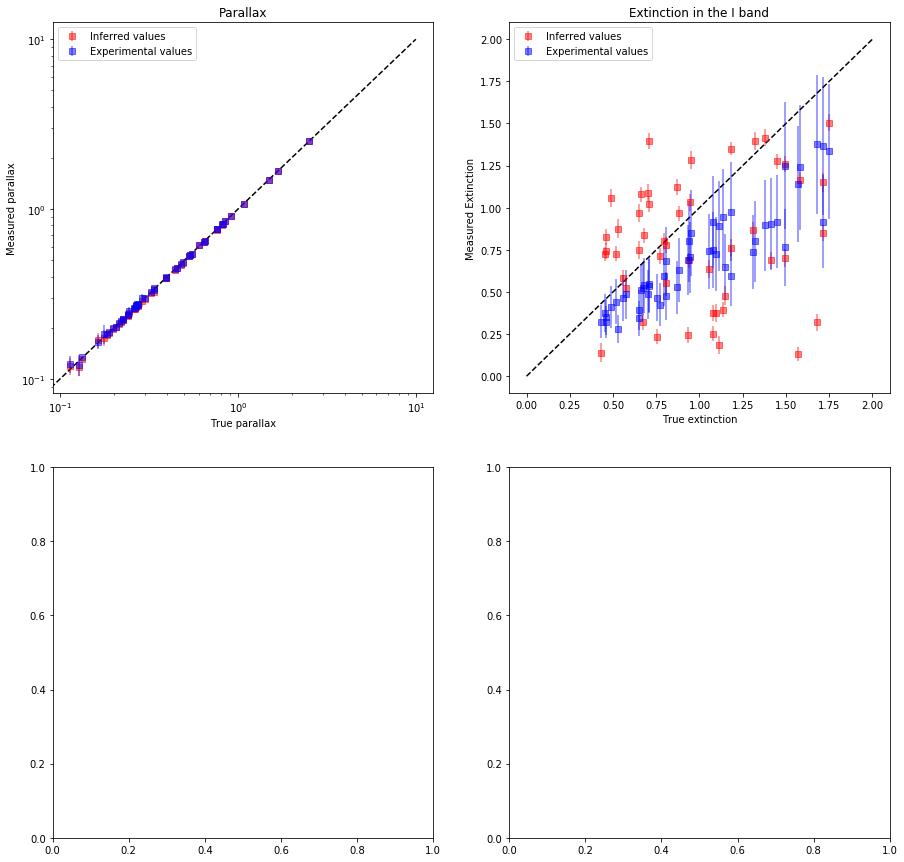

In [76]:
# Let's plot some comparisons on a 2x2 figure!
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

# Parallax

# Calculate lower and upper bounds, also set any NaNs to 0
inf_error = np.array([np.array(data['omega_inf'] - data['omega_inf_l']),
                      np.array(data['omega_inf_u'] - data['omega_inf'])])
inf_error = np.where(np.isfinite(inf_error), inf_error, 0)


ax[0][0].set_title('Parallax')
ax[0][0].set_xscale("log", nonposx='clip')
ax[0][0].set_yscale("log", nonposy='clip')

ax[0][0].errorbar(data['omega_true'], data['omega_inf'], 
                  yerr=inf_error,
                  fmt='sr', label='Inferred values', alpha=0.5
                 )
ax[0][0].errorbar(data['omega_true'], data['omega_exp'], 
                  yerr=data['omega_sigma'],
                  fmt='sb', label='Experimental values', alpha=0.5
                 )
ax[0][0].plot([0, 10], [0, 10], 'k--')
ax[0][0].set_xlabel('True parallax')
ax[0][0].set_ylabel('Measured parallax')
ax[0][0].legend()


# Extinction

band = 'I'
inf_error = np.array([np.array(data['A_inf_' + band] 
                               - data['A_inf_' + band + '_l']),
                      np.array(data['A_inf_' + band + '_u'] 
                               - data['A_inf_' + band])])
inf_error = np.where(np.isfinite(inf_error), inf_error, 0)

ax[0][1].set_title('Extinction in the {} band'.format(band))
ax[0][1].errorbar(data['A_true_' + band], data['A_inf_' + band], 
                  yerr=inf_error,
                  fmt='sr', label='Inferred values', alpha=0.5
                 )
ax[0][1].errorbar(data['A_true_' + band], data['A_exp_' + band], 
                  yerr=data['A_sigma_' + band],
                  fmt='sb', label='Experimental values', alpha=0.5
                 )
ax[0][1].plot([0, 2], [0, 2], 'k--')
ax[0][1].set_xlabel('True extinction')
ax[0][1].set_ylabel('Measured Extinction')
ax[0][1].legend()

plt.show()




In [303]:
np.where(np.isfinite(inf_error), inf_error, 0)

array([[0.0024995 , 0.00242948, 0.00232746, 0.00253512, 0.00247062,
        0.00246114, 0.00222773, 0.00244778, 0.00237021, 0.00241919,
        0.00232135, 0.00250472, 0.00229501, 0.00239298, 0.00246509,
        0.00229455, 0.00228915, 0.00244869, 0.00220031, 0.00234895,
        0.00223518, 0.00253617, 0.00234948, 0.00213198, 0.00253849,
        0.00238922, 0.00237451, 0.00245809, 0.00238954, 0.00239831,
        0.00219874, 0.00217213, 0.0024172 , 0.        , 0.00248402,
        0.00228771, 0.00259713, 0.00244552, 0.00238843, 0.00229674,
        0.00239413, 0.00244876, 0.00242476, 0.00233957, 0.00233196,
        0.00252322, 0.00250716, 0.00225098, 0.00237457, 0.0023455 ,
        0.0022903 , 0.00238427, 0.00247462, 0.00237423, 0.00237395,
        0.00221067, 0.00245542, 0.00237729, 0.00252391, 0.00231022,
        0.00238263, 0.00248497, 0.00219678, 0.00224162, 0.00234384,
        0.00238684, 0.00227232, 0.00242469, 0.00252411, 0.0024257 ,
        0.00249985, 0.00236345, 0.        , 0.00

In [301]:
inf_error

array([[0.0024995 , 0.00242948, 0.00232746, 0.00253512, 0.00247062,
        0.00246114, 0.00222773, 0.00244778, 0.00237021, 0.00241919,
        0.00232135, 0.00250472, 0.00229501, 0.00239298, 0.00246509,
        0.00229455, 0.00228915, 0.00244869, 0.00220031, 0.00234895,
        0.00223518, 0.00253617, 0.00234948, 0.00213198, 0.00253849,
        0.00238922, 0.00237451, 0.00245809, 0.00238954, 0.00239831,
        0.00219874, 0.00217213, 0.0024172 ,        nan, 0.00248402,
        0.00228771, 0.00259713, 0.00244552, 0.00238843, 0.00229674,
        0.00239413, 0.00244876, 0.00242476, 0.00233957, 0.00233196,
        0.00252322, 0.00250716, 0.00225098, 0.00237457, 0.0023455 ,
        0.0022903 , 0.00238427, 0.00247462, 0.00237423, 0.00237395,
        0.00221067, 0.00245542, 0.00237729, 0.00252391, 0.00231022,
        0.00238263, 0.00248497, 0.00219678, 0.00224162, 0.00234384,
        0.00238684, 0.00227232, 0.00242469, 0.00252411, 0.0024257 ,
        0.00249985, 0.00236345,        nan, 0.00

# Deprecated code

## From the maximisation function

In [380]:
def maximise_likelihood(star, data, omega_0, L):
    """Maximises a given star's likelihood in order to find a good initial 
    guess at its parameters.
    
    Currently, this takes omega, omega_0, L, m and M values as given, and only 
    fits for A. This has, in the past, stopped the minimisation function
    from being a colossal prick
    
    If the function fails for whatever reason (usually because it can't stop 
    getting -np.inf for a given star,) then success will be set to False and 
    the star will not be added to the parameters to solve for. If this happens, 
    then the user should really try and work out why (and get the star working)
    before proceeding, to ensure that selection effects stemming from the
    effectiveness of this guesser do not appear in the final model.
    """
    # Assume we're gonna get through ok
    success = True
    
    # A synthetic ranges dictionary to trick posterior() into working
    ranges = {'omega':0,
              'omega_0':1,
              'L':2,
              'A':list(range(3, 3 + 1*N_bands)),
              'm':list(range(3 + 1*N_bands, 3 + 2*N_bands)),
              'M':list(range(3 + 2*N_bands, 3 + 3*N_bands))}
    
    # Set any -ve parallaxes to the PLR implied parallax
    if data['omega_exp'][a_star] <= 0:
        omega = np.power(10, (data['M_exp'][a_star] + data['A_exp'][a_star] 
                                  + 10 - data['m_exp'][a_star]) / 5)
    else:
        omega = data['omega_exp'][a_star]
    
    # Create other guess parameters
    A = data['A_exp'][a_star]
    m = data['m_exp'][a_star]
    M = data['M_exp'][a_star]   
    
    """Check for likelihood_app_mag infinity issues"""
    guess = np.array([omega, omega_0, L, A, m, M])
    likelihood_test = likelihood_app_mag(guess, ranges, data, debug=False)
    if np.isfinite(likelihood_test) == False or likelihood_test < -300:
        print("Star {} gives an instant inf. Attempting to fix.".format(star))
        
        # Slowly change the extinction to see if this fixes the problem
        counter = 1
        while True:
            guess[ranges['A']] += 0.001  
            
            new_likelihood_test = likelihood_app_mag(guess, ranges, data, 
                                                     debug=False)
            
            # If the extinction prior is now false, then I guess we've
            # totally failed to fix this star. =(
            if np.isfinite(prior_extinction(guess, ranges, 
                                            debug=False)) == False:
                print("Prior_extinction is now infinite. Star {} has failed\n"
                      .format(star)
                      + " after {} attempts.".format(counter))
                success = False
                break            
                
            # Otherwise, see if the likelihood is better now:
            elif (np.isfinite(new_likelihood_test) and new_likelihood_test < likelihood_test):
                print("likelihood_app_mag is now finite. Moving on...")
                guess[ranges['A']] -= 0.001  
                break
                
            # Otherwise, update a counter and try the loop again
            else:
                likelihood_test = new_likelihood_test
                counter += 1
                
    """Run scipy minimisation function"""
    if success:
        print("Minimising star {}...".format(star))

        # Remove omega_0, L, m and M from guess so that they're locked
        guess = np.array([omega, A])

        # Multiply the posterior by -1 when returning so that it's 
        # minimized, not maximized
        def function_to_minimize(params, omega_0, L, m, M, ranges, data):
            params = np.insert(params, 1, [omega_0, L])
            params = np.append(params, m)
            params = np.append(params, M)
            return -1 * posterior(params, ranges, data)

        # Actually do the scipy bit
        result = minimize(function_to_minimize, guess, 
                 args=(omega_0, L, m, M, ranges, data), 
                 method='Nelder-Mead',
                 options={'maxiter':2000})

        # 'result' is a scipy.optimize.OptimizeResult object that we need 
        # to split up
        omega = result.x[ranges['omega']]
        A = result.x[list(np.array(ranges['A']) - 2)]
        success = result.success
        
        a_posterior = -1 * function_to_minimize([omega, A], omega_0, 
                            L, m, M, ranges, data)
        
        if success and np.isfinite(a_posterior):
            print("  minimised star {}. Posterior = {}. Omega = {}. A = {}\n"
                  .format(star, a_posterior, omega, A))
        else:
            print("Minimisation failed on star {} after ??? iterations =(\n"
                  .format(star))
    
    return [success, omega, A, m, M]

## More from the maximisation function (how it was at the start of batdog_begins)

In [162]:
def maximise_likelihood(star, data, omega_0, L):
    """Maximises a given star's likelihood in order to find a good initial 
    guess at its parameters.
    
    Currently, this takes omega, omega_0, L, m and M values as given, and only 
    fits for A. This has, in the past, stopped the minimisation function
    from being a colossal prick
    
    If the function fails for whatever reason (usually because it can't stop 
    getting -np.inf for a given star,) then success will be set to False and 
    the star will not be added to the parameters to solve for. If this happens, 
    then the user should really try and work out why (and get the star working)
    before proceeding, to ensure that selection effects stemming from the
    effectiveness of this guesser do not appear in the final model.
    """
    # Console output
    print("\n> Creating a guess for star {}".format(star))
    
    # Assume failure because I have to typecast this.. somewhere. Why not here?
    A_success = False
       
    # Get input parameters to use from data
    A = data['A'][:, star]
    P = data['P'][star]
    m = data['A'][:, star]
    
    
    """Solve for parallax"""
    # We calculate good input data for scipy, and then feed this to the
    # minimisation method.
    def function_to_minimize(omega, omega_0, L, A, m, M, ranges, data):
        """Minimisation function for use with scipy. We multiply by -1 so 
        we're minimising, not maximising!
        """
        # Pop everything in a np.array to interface with existing fns
        params = np.array([omega, omega_0, L, A, m, M])

        return -1*(np.sum(likelihood_parallax(params, ranges, data, True)) 
                   + np.sum(prior_parallax(params, ranges, True)))
    
    # Calculate different initial estimates of the parallax & their probability
    omega_exp = data['omega_exp'][star]
    omega_PLR = np.power(10, (data['M_exp'][a_star] + data['A_exp'][a_star] 
                                  + 10 - data['m_exp'][a_star]) / 5)
    omega_prior = 1/(2*L) * 1e3
    prob_exp = function_to_minimize(omega_exp, omega_0, L, 
                                    A, m, M, ranges, data)
    prob_PLR = function_to_minimize(omega_PLR, omega_0, L, 
                                    A, m, M, ranges, data)
    prob_prior = function_to_minimize(omega_prior, omega_0, L, 
                                      A, m, M, ranges, data)
    
    # Minimise with the most likely 
    if prob_exp < prob_PLR and prob_exp < prob_prior and np.isfinite(prob_exp):
        print("    using experimental parallax value for first guess")
        omega = omega_exp
        omega_success = True
    elif prob_PLR < prob_prior and np.isfinite(prob_PLR):
        print("    using PLR parallax value for first guess")
        omega = omega_PLR
        omega_success = True
    elif np.isfinite(prob_prior):
        print("    using prior parallax value for first guess")
        omega = omega_prior
        omega_success = True
        
    # If all else fails, brute force through parameter space to try and find
    # a value to use. Ranges need setting manually.
    else:
        print("    ah shit nothing has worked yet")
        print("    gonna do this the hard way with 1000 samples...")
        omega_sampled = np.linspace(0.001, 2.0, num=1000)
        prob_sampled = []
        for i in omega_sampled:
            params = np.array([i, 0.0, 1000.0, 0.0, 0.0, 0.0])
            prob_sampled.append(function_to_minimize(i, omega_0, L, 
                                                     A, m, M, ranges, data))
        
        # See if *literally any* of the values are good
        if np.any(np.isfinite(prob_sampled)):
            print("    using sampled parallax value for first guess")
            index_of_minimum = np.argmin(prob_sampled)
            omega = omega_sampled[index_of_minimum]
            omega_success = True
        else:
            print("~~~ failed to make initial omega guess =(")
            omega_success = False
        
    # Minimise with scipy if the above worked and we have a good initial guess
    if omega_success:
        result = minimize(function_to_minimize, omega, 
                          args=(omega_0, L, A, m, M, ranges, data), 
                          method='Nelder-Mead',
                          options={'maxiter':2000, 'disp':True})
    
        # Pull the results out of result, which is a 
        # scipy.optimize.OptimizeResult object that needs care, love, 
        # attention, and the US spelling of optimise
        omega_success = result.success

        # Tell the user that everything went well (hopefully (maybe))
        if omega_success:
            omega_guess = result.x
            print("    guessed omega at {}".format(omega_guess))
        else:
            print("~~~ scipy failed to guess omega =(")
    
    
    """Solve for extinction"""
    # This is easily done with the PLR relationship and using the guessed
    # parallax above to infer an extinction value.
    if omega_success:
        A_guess = m - M - 10 + 5*np.log10(omega_guess)
        print("    guessed A at {}".format(A_guess))
        print("    original A was {}".format(data['A_exp'][star]))
        
        # Check that the posterior for this star isn't something stupid
        # If it is, then we've fucked up lol
        params_guess = np.array([omega_guess, omega_0, L, A_guess, m, M])
        posterior_guess = posterior(params_guess, ranges, data, debug=True)
        A_success = np.isfinite(posterior_guess)
        print("    posterior evaluates to {}".format(posterior_guess))
        
        if A_success == False:
            print("~~~ failed to guess A due to poor posterior")   
    
    
    """Return result"""
    if A_success:
        print("    storing this good result for star {}".format(star))
        return [omega_guess, A_guess, m, M]
        
    else:
        print("~~~ star {} will not be stored in the final model".format(star))
        return [False]

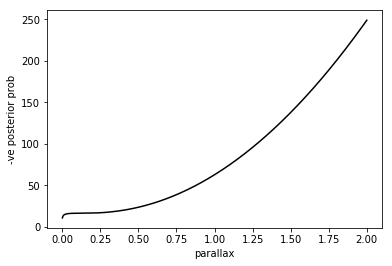

In [172]:
ranges = {'omega':0,
          'omega_0':1,
          'L':2,
          'A':list(range(3, 3 + 1*N_bands)),
          'm':list(range(3 + 1*N_bands, 3 + 2*N_bands)),
          'M':list(range(3 + 2*N_bands, 3 + 3*N_bands))}

a_star = 33

##############

some_data = data.iloc[[a_star]]
a_A = some_data['A_exp'][a_star]
a_m = some_data['m_exp'][a_star]
a_M = some_data['M_exp'][a_star]

xrange = np.linspace(0.001, 2.0, num=1000)
yrange = []
for i in xrange:
    params = np.array([i, 0.0, 1000.0, 0.0, 0.0, 0.0])
    yrange.append(-1*(np.sum(likelihood_parallax(params, ranges, some_data, True)) 
                   + np.sum(prior_parallax(params, ranges, True))))
    
plt.plot(xrange, yrange, 'k-')
plt.xlabel('parallax')
plt.ylabel('-ve posterior prob')
plt.show()


## Run the maximisation function for all stars

In [167]:
# Define ranges that will be where data is stored in the overall
# mcmc position vector.

guess_omega = []
guess_A = []
guess_m = []
guess_M = []
guess_successes = []
guess_fails = []

# Cycle over all stars and get guesses on their parameters
for a_star in range(N):
    maximisation_result = maximise_likelihood(a_star, data.iloc[[a_star]],
                                              guess_omega_0, guess_L)
    
    # Only add the star to the parameter set if it's not going to cause issues.
    # We ascertain this with np.any(), which returns False for [False] (as the 
    # single array element in that isn't true)
    if np.any(maximisation_result):
        guess_omega.append(maximisation_result[0])
        guess_A.append(maximisation_result[1])
        guess_m.append(maximisation_result[2])
        guess_M.append(maximisation_result[3])
        guess_successes.append(a_star)
    else:
        guess_fails.append(a_star)

print('All done! We failed {} times.'.format(len(guess_fails)))


> Creating a guess for star 0
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 17.462566
         Iterations: 10
         Function evaluations: 20
    guessed omega at [0.57986574]
    guessed A at [1.08599221]
    original A was 0.8896045984425304
    posterior evaluates to -10.334307268996515
    storing this good result for star 0

> Creating a guess for star 1
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 18.137256
         Iterations: 10
         Function evaluations: 20
    guessed omega at [0.76338401]
    guessed A at [1.976072]
    original A was 1.5387955952605645
    posterior evaluates to -13.276337638793482
    storing this good result for star 1

> Creating a guess for star 2
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 14.844119
         I

/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log



    guessed omega at [0.24915696]
    guessed A at [2.18889264]
    original A was 1.2242519253636444
    posterior evaluates to -11.069788450392316
    storing this good result for star 7

> Creating a guess for star 8
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 16.757386
         Iterations: 9
         Function evaluations: 18
    guessed omega at [0.464878]
    guessed A at [1.92226384]
    original A was 1.5330862335554545
    posterior evaluates to -9.636968223249294
    storing this good result for star 8

> Creating a guess for star 9
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 16.666752
         Iterations: 9
         Function evaluations: 18
    guessed omega at [0.47155286]
    guessed A at [1.31159256]
    original A was 0.7331084931731461
    posterior evaluates to -9.83673980551529
    storing this good result fo

Optimization terminated successfully.
         Current function value: 10.509467
         Iterations: 23
         Function evaluations: 46
    guessed omega at [0.00050143]
    guessed A at [-11.1951979]
    original A was 0.7143572367220545

prior_extinction encountered infs in:
(array([0]),)
    posterior evaluates to -inf
~~~ failed to guess A due to poor posterior
~~~ star 33 will not be stored in the final model

> Creating a guess for star 34
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 16.286517
         Iterations: 9
         Function evaluations: 18
    guessed omega at [0.42090971]
    guessed A at [1.9548167]
    original A was 1.1749025876386152
    posterior evaluates to -10.404522161291164
    storing this good result for star 34

> Creating a guess for star 35

likelihood_parallax encountered infs in:
(array([0]),)
    using experimental parallax value for first guess
Optimization terminated 

Optimization terminated successfully.
         Current function value: 17.556038
         Iterations: 10
         Function evaluations: 20
    guessed omega at [0.69711892]
    guessed A at [1.49936081]
    original A was 0.9074466029426809
    posterior evaluates to -13.430108752040343
    storing this good result for star 61

> Creating a guess for star 62
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 15.455422
         Iterations: 9
         Function evaluations: 18
    guessed omega at [0.2757178]
    guessed A at [0.50890745]
    original A was 0.31484434906427816
    posterior evaluates to -8.95072440882705
    storing this good result for star 62

> Creating a guess for star 63
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 15.334695
         Iterations: 9
         Function evaluations: 18
    guessed omega at [0.28006289]
 

    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 16.222425
         Iterations: 9
         Function evaluations: 18
    guessed omega at [0.33155923]
    guessed A at [0.87401566]
    original A was 0.6530081631504009
    posterior evaluates to -10.777455070876172
    storing this good result for star 79

> Creating a guess for star 80
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 14.837501
         Iterations: 8
         Function evaluations: 16
    guessed omega at [0.19624982]
    guessed A at [0.59852027]
    original A was 0.3379103267555543
    posterior evaluates to -9.558340529885207
    storing this good result for star 80

> Creating a guess for star 81

likelihood_parallax encountered infs in:
(array([0]),)

likelihood_parallax encountered infs in:
(array([0]),)
    using experimental parallax value for first guess
Optimiz

Optimization terminated successfully.
         Current function value: 16.735301
         Iterations: 13
         Function evaluations: 26
    guessed omega at [1.39795912]
    guessed A at [1.46902115]
    original A was 0.8696739177212992
    posterior evaluates to -10.83943525594211
    storing this good result for star 97

> Creating a guess for star 98
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 17.060137
         Iterations: 9
         Function evaluations: 18
    guessed omega at [0.47793537]
    guessed A at [0.40481861]
    original A was 0.16956816999053828
    posterior evaluates to -10.29733296920159
    storing this good result for star 98

> Creating a guess for star 99
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 16.218853
         Iterations: 9
         Function evaluations: 18
    guessed omega at [0.31454607]


In [178]:
data.iloc[[47]]

,ID,ra,dec,r_true,omega_true,P_true,s_true,M_true,A_true,m_true,omega_exp,omega_sigma,m_exp,m_sigma,A_exp,A_sigma,P_exp,P_sigma,M_exp,M_sigma
47,47,173.806324,-61.025872,3829.266374,0.261147,18.728441,0.0,2.264246,0.327156,15.50698,0.253377,0.018816,15.506086,0.001341,0.178841,0.143073,18.618057,0.110836,2.271177,0.047001


In [168]:
guess_fails

[33, 72]

In [20]:
np.arange(0, 10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Test of how matrices work in numpy

In [9]:
hi = np.array([[2, 2], 
               [0, 0],
               [-2, -2]])

me = np.array([1, 3])

hi * me

array([[ 2,  6],
       [ 0,  0],
       [-2, -6]])

## Old ranges code

In [ ]:
ranges = {'omega':list(range(0,N_good)),
          'omega_0':N_good,
          'L':N_good+1,
          'A':list(range(N_good+2, N_good+2 + 1*N_good*N_bands)),
          'm':list(range(N_good+2 + 1*N_good*N_bands, N_good+2 + 2*N*N_bands)),
          'M':list(range(N_good+2 + 2*N_good*N_bands, N_good+2 + 3*N*N_bands))}